In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import re
import string




In [3]:
df_fake = pd.read_csv('ML KNN Overview Fake.txt', header=None)
df_real = pd.read_csv('ML KNN Overview Real.txt', header=None)

# Đặt tên cột là 'title'
df_fake.columns = ['title']
df_real.columns = ['title']

# Hiển thị 5 hàng đầu tiên của DataFrame
print(df_fake.head())
print(df_real.head())


                                               title
0           trump warns of vote flipping on machines
1  this election is not about trump its about a g...
2  more on trump populism and how it can be contr...
3  trump bollywood ad meant to sway indian americ...
4  dems could be up on charges for inciting trump...
                                               title
0  donald trump do you remember the year since he...
1  trump defends son over emails as moscow hits back
2  donald trump strategist says media wont easily...
3  anthony scaramucci who is donald trumps new co...
4  donald trumps mobile phone use worries securit...


### Inserting a column "class" as target feature

In [4]:
df_fake['class']=0
df_real['class']=1

In [5]:
df_fake.shape,df_real.shape

((1298, 2), (1968, 2))

In [6]:
# Additional preprocessing functions
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text

# Apply preprocessing
df_fake['title'] = df_fake['title'].apply(preprocess_text)
df_real['title'] = df_real['title'].apply(preprocess_text)

In [8]:
# Combine fake and real data
df = pd.concat([df_fake, df_real])
X = df['title']
y = df['class']


In [9]:
df


,title,class
0,trump warns of vote flipping on machines,0
1,this election is not about trump its about a g...,0
2,more on trump populism and how it can be contr...,0
3,trump bollywood ad meant to sway indian americ...,0
4,dems could be up on charges for inciting trump...,0
...,...,...
1963,donald trump tells guam north korean threat a ...,1
1964,abc news quiz trump golden globes,1
1965,cancel it trump says new air force one cost ri...,1
1966,trump trade policies easier said than done,1


## Split the data set

In [11]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction using TF-IDF
max_features = 5000  # Limit the number of features
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=max_features)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Shape of training data before oversampling: (2612, 4933) 




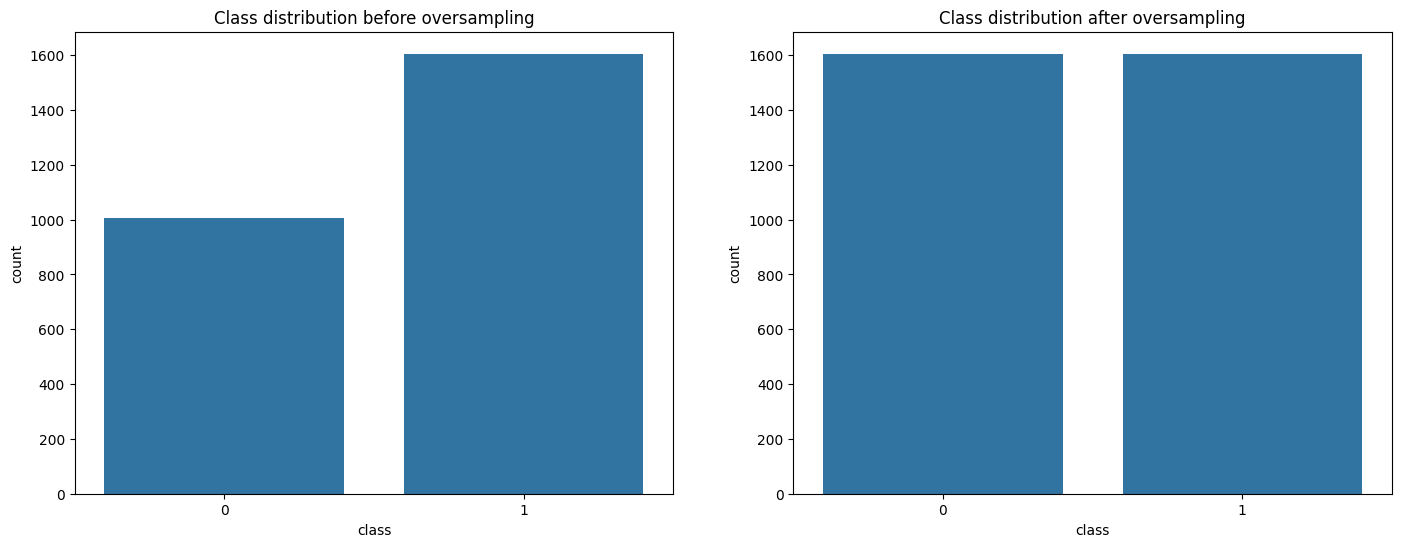

Shape of training data after oversampling: (3210, 4933)


In [21]:
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# Visualize class imbalance before oversampling
plt.figure(1, figsize=(17, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class distribution before oversampling')
print('Shape of training data before oversampling:', X_train_tfidf.shape, '\n\n')
# Perform oversampling using RandomOverSampler
ros = RandomOverSampler()
X_train_tfidf_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)

# Visualize class distribution after oversampling
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_res)
plt.title('Class distribution after oversampling')
plt.show()
print('Shape of training data after oversampling:', X_train_tfidf_res.shape)



### Training model with LogisticRegression

In [20]:
model=LogisticRegression()
model.fit(X_train_tfidf_res, y_train_res)

LogisticRegression()

In [ ]:
y_pred=model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)